# Select a representative sample of articles per quarter

Our goal is to extract the sentiment of the articles over time to analyze whether or not there has been a variation on the way that migration topic has been addressed by Der Spiegel in the last years.

For this aim we will use a pre-trained LSTM model. However, it takes some time on predicting the sentiment of long texts (sentiment prediction of text with 642 words took half an hour in a 4 cores MacBook Air). Therefore, we are going to remove articles with more than 700 words and we will take a representation of each quarter with 30 articles.

Due to the lack of labeled training datasets in german and, therefore, lack of robusst pre-trained sentiment models we will translate selected articles to english through the Google Translate API and apply existing models to the result.

In [1]:
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sys.path.append("../..")
from src.helpers import assign_quarter_labels, get_quarter_boundaries
from src.translator import extract_n_articles_and_translate, google_translator
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [5]:
# Use the German stopwords.
stpwrds = stopwords.words("german")

# We added some additional characters to avoid.
characters = [',', '.', '(', ')', '!', ';', '-', ':', '...', '"',
                "''", "``", '~http', '?', '@', '#', '/', "'",
                '&', '--', '[', ']', '=', '||', '+', '_', '..',
                '%', '|', '~', 'http',"\n","—","•","“","„","–",
                "في","שראל","россии","не","минобороны","и","в",
                "את", "$",">","*"]

# Selection of articles parameters
# number of top articles with higher frequencies on key words for selecting the final ones
n_pre_selected = 75
n_articles = 30
language = 'en'

In [8]:
# Load selected articles about migration
articles = pd.read_csv("../../data/migration_articles.csv")
articles.date = articles['date'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d"))

In [9]:
articles[(articles['date'].dt.year == 2015) & (articles['quarter'] == 'q11_18')]

,text,date,meta_description,time_line,quarter,is_summary,text_length,article_id,freq


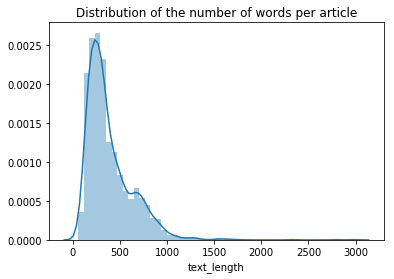

In [5]:
# Explore the distribution of number of words per article
articles['text_length'] = articles['text'].apply(lambda x: len(x.split(" ")))
_=sns.distplot(articles['text_length'])
_=plt.title("Distribution of the number of words per article")

It looks like there are two main types of articles, short ones of around 300 words and longer ones of around 700. We will get focused on the short ones in the sentiment analysis for performance reasons fixing the length threshold at 700 words.

In [6]:
articles_short = articles[articles["text_length"] < 700].reset_index(drop=True)

In [7]:
articles_short.head()

,text,date,meta_description,time_line,quarter,is_summary,text_length,article_id,freq
0,Die Offensive von Baschar al-Assad im Süden Sy...,2018-07-09,Syrien plant einen Angriff auf die Golanhöhen....,32080,q11_18,0,559,32080,0.011696
1,In der Debatte um die Asylpolitik in Deutschla...,2018-07-09,Entwicklungshilfeminister Gerd Müller (CSU) ha...,32071,q11_18,0,249,32071,0.012903
2,Wenige Tage vor dem EU-Ministertreffen in Inns...,2018-07-08,Italien weist bereits Schiffe von Hilfsorganis...,32062,q11_18,0,314,32062,0.018779
3,Der Vorwurf wiegt schwer: Niedersachsens Innen...,2018-07-08,Niedersachsens Innenminister Pistorius soll ei...,32056,q11_18,0,265,32056,0.013072
4,"Liebe Abonnentin, lieber Abonnent,\n\nin unser...",2018-07-07,Deutschlands führende Nachrichtenseite. Alles ...,32033,q11_18,0,513,32033,0.010033


In [64]:
print(f"There are {len(articles_short)} articles about migration with less than 700 words.")

There are 2388 articles about migration with less than 700 words.


### Select a set of 30 articles per quarter

In [120]:
#articles_selected_ = extract_n_articles_and_translate(articles_short, n_pre_selected, n_articles, language)

In [71]:
# Goole translate API can not translate all the artcles at once and therefore we need to run it several times
if len(articles_selected_[articles_selected_["text_en"].isnull()]) > 0:
    # translate articles that for some reason were not translated
    non_translated = articles_selected_[articles_selected_["text_en"].isnull()]
    non_translated["text_en"] = non_translated["text"].apply(lambda x: google_translator(x, language))
    
    translated = non_translated[non_translated['text_en'] != '']
    
    # update translations
    articles_to_replace = translated.index.tolist()
    for art in articles_to_replace:
        articles_selected_.loc[art, "text_en"] =  translated.loc[art, "text_en"]

In [72]:
# ensure that all texts are translated
articles_selected_[articles_selected_["text_en"].isnull()]

,text,date,meta_description,time_line,quarter,is_summary,text_length,article_id,freq,text_en


In [90]:
articles_selected_.to_csv("../../data/330_selected_art_translated.csv", index=False, encoding='utf-8')

#### Extract articles IDs of the analyzed articles to match sentiment to date

In [6]:
articles_selected = pd.read_csv("../../data/330_selected_art_translated.csv")
articles_selected.date = articles_selected['date'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d"))

In [10]:
articles_sel_correct = articles_selected.loc[:,('date','quarter',
                         'time_line','text_en')].rename(columns={'quarter':'wrong_q'}).merge(articles.loc[:,('date',
                                         'quarter','time_line')],
                                            left_on='time_line', right_on='time_line')

In [11]:
articles_sel_correct[(articles_sel_correct['date_x'].dt.year == 2015) & (articles_sel_correct['quarter'] == 'q11_18')]

,date_x,wrong_q,time_line,text_en,date_y,quarter


In [20]:
articles_sel_correct.to_csv("../../data/330_selected_art_translated_correct.csv", index=False, encoding='utf-8')